In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class ShortCorridor:
    def __init__(self):
        self.action_space = 2
        self.state_space = 4
        self.state = 0
        
    def reset(self):
        self.state = 0
        return self.state
        
    def step(self, action):
        if self.state == 0:
            if action == 1:
                self.state += 1
                
        elif self.state == 1:
            if action == 0:
                self.state += 1
            elif action == 1:
                self.state -= 1
            
        elif self.state == 2:
            if action == 0:
                self.state -= 1
            elif action == 1:
                self.state += 1
                
        return self.state, -1, True if self.state == 3 else False

In [3]:
def feature_vector(action):
    fv = np.zeros(2)
    fv[action] = 1
    return fv

In [4]:
class MCPolicyGradient:
    def __init__(self, env, alpha=2e-4, gamma=1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.theta = np.array([+1.5, -1.5])
        
    def estimate(self, n_episodes):
        returns = np.zeros(n_episodes)
        for i in range(n_episodes):
            state_action, rewards = self.generate_episode()
            G = 0
            for t in reversed(range(len(state_action))):
                G = self.gamma * G + rewards[t]
                pi = np.exp(self.theta) / np.sum(np.exp(self.theta))
                gradient = feature_vector(state_action[t][1]) - pi
                self.theta += self.alpha * np.power(self.gamma, t) * G * gradient
            returns[i] = G
        return returns
    
    def iterate(self, n_runs, n_episodes):
        sum_returns = np.zeros(n_episodes)
        for i in tqdm(range(n_runs)):
            self.reset()
            sum_returns += self.estimate(n_episodes)
        return sum_returns/n_runs

            
    def generate_episode(self):
        state_action, rewards = [], []
        state = self.env.reset()
        while True:
            action = self.policy(state)
            state_action.append((state, action))
            s_p, reward, done = self.env.step(action)
            rewards.append(reward)
            if done:
                break
            state = s_p
        return state_action, rewards
            
    def policy(self, state):
        epsilon = 0.05
        actions = [0,1]
        h = self.theta
        pi = np.exp(h) / np.sum(np.exp(h))
        mini = np.argmin(pi)
        if pi[mini] < epsilon:
            pi[:] = 1 - epsilon
            pi[mini] = epsilon

        return np.random.choice(actions, p=pi)
    
    def reset(self):
        self.theta = np.array([+1.5, -1.5])
        

In [5]:
sc = ShortCorridor()

result3 = MCPolicyGradient(sc, alpha=2e-3).iterate(100,1000)
result4 = MCPolicyGradient(sc, alpha=2e-4).iterate(100,1000)
result5 = MCPolicyGradient(sc, alpha=2e-5).iterate(100,1000)

100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


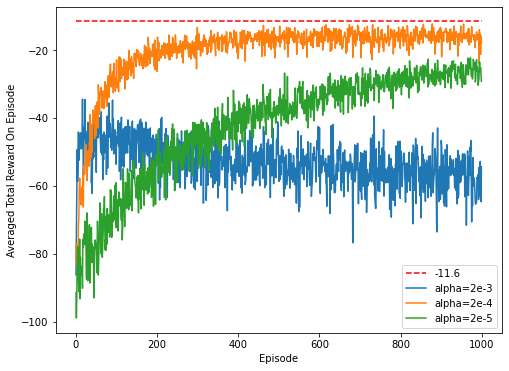

In [22]:
plt.figure(figsize=(8,6))
plt.plot([0, 1000], [-11.6, -11.6], ls='dashed', color='red', label='-11.6')
plt.plot(result3, label="alpha=2e-3")
plt.plot(result4, label="alpha=2e-4")
plt.plot(result5, label="alpha=2e-5")
plt.xlabel('Episode')
plt.ylabel('Averaged Total Reward On Episode')
plt.legend()
plt.show()

In [7]:
class MCPloicyGradientBaseline(MCPolicyGradient):
    def __init__(self, env, alpha_theta=2e-4, alpha_weight=2e-3, gamma=1):
        self.env = env
        self.alpha_theta = alpha_theta
        self.alpha_weight = alpha_weight
        self.gamma = gamma
        self.theta = np.array([+1.47, -1.47])
        self.weight = np.zeros(2)

    def estimate(self, n_episodes):
        returns = np.zeros(n_episodes)
        for i in range(n_episodes):
            state_action, rewards = self.generate_episode()
            G = 0
            for t in reversed(range(len(state_action))):
                G = self.gamma * G + rewards[t]
                pi = np.exp(self.theta) / np.sum(np.exp(self.theta))
                
                delta = G - self.weight
                
                self.weight += self.alpha_weight * delta * feature_vector(state_action[t][1])
                
                gradient = feature_vector(state_action[t][1]) - pi
                self.theta += self.alpha_theta * np.power(self.gamma, t) * delta * gradient
            returns[i] = G
        return returns

In [8]:
sc = ShortCorridor()

result_baseline = MCPloicyGradientBaseline(sc, alpha_theta=2e-3, alpha_weight=2e-2).iterate(100,1000)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


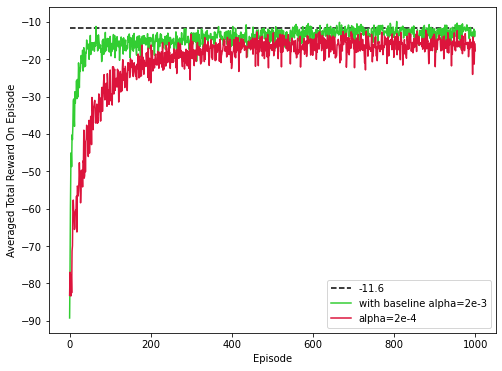

In [21]:
plt.figure(figsize=(8,6))
plt.plot([0, 1000], [-11.6, -11.6], ls='dashed', color='black', label='-11.6')
plt.plot(result_baseline, color='limegreen', label="with baseline alpha=2e-3")
plt.plot(result4, color='crimson', label="alpha=2e-4")
plt.xlabel('Episode')
plt.ylabel('Averaged Total Reward On Episode')
plt.legend()
plt.show()